In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# -------------------
# Load CSV
# -------------------
df = pd.read_csv('combined_crop_disease_labels.csv')
df['label_encoded'] = pd.factorize(df['label'])[0]
df['label_str'] = df['label'].astype(str)  # For ImageDataGenerator

# Parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20
N_SPLITS = 10

In [3]:
# -------------------
# CNN Model Builder
# -------------------
def build_cnn_model(input_shape=(256, 256, 3), num_classes=None):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
# -------------------
# K-Fold Cross Validation
# -------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# For ROC curve plotting later
roc_data = []

for train_idx, val_idx in skf.split(df, df['label_encoded']):
    print(f"\n===== Fold {fold_no} =====")
    
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    
    # Generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='label_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',
        y_col='label_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Build & train model
    model = build_cnn_model(input_shape=(256, 256, 3),
                            num_classes=len(train_gen.class_indices))
    
    early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Save model
    model.save(f"model_fold_{fold_no}.h5")
    
    # Evaluate
    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold_no} - Loss: {scores[0]:.4f}, Accuracy: {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    
    # Predictions for ROC
    y_pred = model.predict(val_gen)
    y_true = val_gen.classes
    class_labels = list(val_gen.class_indices.keys())
    
    # Compute ROC for each class
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))
    
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        roc_data.append((fold_no, class_labels[i], fpr, tpr, roc_auc))
    
    fold_no += 1


===== Fold 1 =====
Found 43638 validated image filenames belonging to 26 classes.
Found 4849 validated image filenames belonging to 26 classes.


2025-08-10 23:22:41.951427: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-08-10 23:22:41.951463: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-08-10 23:22:41.951477: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-08-10 23:22:41.951492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-10 23:22:41.951502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` clas

Epoch 1/20


2025-08-10 23:22:42.681561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 141s 102ms/step - accuracy: 0.4104 - loss: 1.9457 - val_accuracy: 0.5490 - val_loss: 1.3922
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 137s 101ms/step - accuracy: 0.6660 - loss: 1.0045 - val_accuracy: 0.6746 - val_loss: 1.0193
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 141s 103ms/step - accuracy: 0.7347 - loss: 0.7982 - val_accuracy: 0.7804 - val_loss: 0.6496
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.7637 - loss: 0.7021 - val_accuracy: 0.7468 - val_loss: 0.7786
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.7883 - loss: 0.6256 - val_accuracy: 0.5358 - val_loss: 2.3398
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.8094 - loss: 0.5722 - val_accuracy: 0.7835 - val_loss: 0.6763
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.8121 - loss: 0.5606 - val_accuracy: 0.7020 - val_loss: 1.0738


Fold 1 - Loss: 0.6496, Accuracy: 78.04%
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step

===== Fold 2 =====
Found 43638 validated image filenames belonging to 26 classes.
Found 4849 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 102ms/step - accuracy: 0.4067 - loss: 1.9235 - val_accuracy: 0.5106 - val_loss: 1.4199
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.6641 - loss: 1.0015 - val_accuracy: 0.5828 - val_loss: 1.3120
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.7337 - loss: 0.7900 - val_accuracy: 0.6902 - val_loss: 0.9762
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.7685 - loss: 0.6881 - val_accuracy: 0.7595 - val_loss: 0.7696
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.7861 - loss: 0.6319 - val_accuracy: 0.7373 - val_loss: 0.8605
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.8017 - loss: 0.5922 - val_accuracy: 0.8088 - val_loss: 0.6094
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.8147 - loss: 0.5508 - val_accuracy: 0.8431 - val_loss: 0.4880
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.8

Fold 2 - Loss: 0.3675, Accuracy: 88.72%
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step

===== Fold 3 =====
Found 43638 validated image filenames belonging to 26 classes.
Found 4849 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 137s 99ms/step - accuracy: 0.4030 - loss: 1.9607 - val_accuracy: 0.3316 - val_loss: 3.6689
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 136s 100ms/step - accuracy: 0.6511 - loss: 1.0422 - val_accuracy: 0.5696 - val_loss: 1.2469
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 136s 100ms/step - accuracy: 0.7272 - loss: 0.8137 - val_accuracy: 0.6641 - val_loss: 1.0116
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 136s 100ms/step - accuracy: 0.7606 - loss: 0.7109 - val_accuracy: 0.7781 - val_loss: 0.6834
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 136s 100ms/step - accuracy: 0.7873 - loss: 0.6272 - val_accuracy: 0.8037 - val_loss: 0.6511
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 136s 99ms/step - accuracy: 0.8059 - loss: 0.5847 - val_accuracy: 0.7154 - val_loss: 1.1513
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 136s 99ms/step - accuracy: 0.8182 - loss: 0.5461 - val_accuracy: 0.6756 - val_loss: 1.2463
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 136s 100ms/step - accuracy: 0.8260

Fold 3 - Loss: 0.3669, Accuracy: 87.81%
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step

===== Fold 4 =====
Found 43638 validated image filenames belonging to 26 classes.
Found 4849 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 143s 104ms/step - accuracy: 0.3890 - loss: 2.0089 - val_accuracy: 0.6148 - val_loss: 1.1545
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 141s 103ms/step - accuracy: 0.6544 - loss: 1.0323 - val_accuracy: 0.7542 - val_loss: 0.7462
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 103ms/step - accuracy: 0.7207 - loss: 0.8323 - val_accuracy: 0.7612 - val_loss: 0.7076
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 103ms/step - accuracy: 0.7602 - loss: 0.7170 - val_accuracy: 0.7802 - val_loss: 0.6528
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 103ms/step - accuracy: 0.7852 - loss: 0.6479 - val_accuracy: 0.7243 - val_loss: 0.8388
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 103ms/step - accuracy: 0.7946 - loss: 0.6013 - val_accuracy: 0.7459 - val_loss: 0.7829
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 102ms/step - accuracy: 0.8120 - loss: 0.5726 - val_accuracy: 0.8204 - val_loss: 0.5207
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 141s 103ms/step - accuracy: 0.8

Fold 4 - Loss: 0.3330, Accuracy: 89.63%
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step

===== Fold 5 =====
Found 43638 validated image filenames belonging to 26 classes.
Found 4849 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 142s 103ms/step - accuracy: 0.3998 - loss: 1.9469 - val_accuracy: 0.6702 - val_loss: 0.9885
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.6607 - loss: 1.0168 - val_accuracy: 0.7336 - val_loss: 0.7763
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 102ms/step - accuracy: 0.7271 - loss: 0.8088 - val_accuracy: 0.7556 - val_loss: 0.7231
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.7673 - loss: 0.6880 - val_accuracy: 0.7822 - val_loss: 0.6292
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.7847 - loss: 0.6366 - val_accuracy: 0.6756 - val_loss: 1.1353
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.8086 - loss: 0.5783 - val_accuracy: 0.7395 - val_loss: 0.9148
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.8162 - loss: 0.5574 - val_accuracy: 0.7476 - val_loss: 0.8939
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.8

Fold 5 - Loss: 0.6292, Accuracy: 78.22%
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step

===== Fold 6 =====
Found 43638 validated image filenames belonging to 26 classes.
Found 4849 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 137s 99ms/step - accuracy: 0.4038 - loss: 2.0034 - val_accuracy: 0.6364 - val_loss: 1.1142
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.6565 - loss: 1.0289 - val_accuracy: 0.6344 - val_loss: 1.2788
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.7245 - loss: 0.8193 - val_accuracy: 0.6923 - val_loss: 0.9551
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.7677 - loss: 0.7004 - val_accuracy: 0.8142 - val_loss: 0.5790
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 135s 99ms/step - accuracy: 0.7888 - loss: 0.6289 - val_accuracy: 0.8039 - val_loss: 0.5526
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 135s 99ms/step - accuracy: 0.8022 - loss: 0.5981 - val_accuracy: 0.7882 - val_loss: 0.6632
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.8137 - loss: 0.5587 - val_accuracy: 0.8313 - val_loss: 0.4806
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 135s 99ms/step - accuracy: 0.8215 - lo

Fold 6 - Loss: 0.3494, Accuracy: 88.88%
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step

===== Fold 7 =====
Found 43638 validated image filenames belonging to 26 classes.
Found 4849 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 141s 102ms/step - accuracy: 0.4012 - loss: 1.9532 - val_accuracy: 0.5246 - val_loss: 1.4250
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.6663 - loss: 0.9926 - val_accuracy: 0.3964 - val_loss: 2.1858
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.7320 - loss: 0.7862 - val_accuracy: 0.7752 - val_loss: 0.6657
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.7723 - loss: 0.6665 - val_accuracy: 0.5946 - val_loss: 1.3399
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.7896 - loss: 0.6208 - val_accuracy: 0.7804 - val_loss: 0.6691
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.8051 - loss: 0.5741 - val_accuracy: 0.7505 - val_loss: 0.7811
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.8211 - loss: 0.5319 - val_accuracy: 0.8006 - val_loss: 0.6439
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.8

Fold 7 - Loss: 0.3856, Accuracy: 87.61%
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step

===== Fold 8 =====
Found 43639 validated image filenames belonging to 26 classes.
Found 4848 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 101ms/step - accuracy: 0.4051 - loss: 1.9297 - val_accuracy: 0.6203 - val_loss: 1.1198
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.6455 - loss: 1.0458 - val_accuracy: 0.6147 - val_loss: 1.1455
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.7205 - loss: 0.8201 - val_accuracy: 0.7791 - val_loss: 0.6592
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.7547 - loss: 0.7234 - val_accuracy: 0.7217 - val_loss: 0.8197
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.7832 - loss: 0.6465 - val_accuracy: 0.7995 - val_loss: 0.5781
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.7994 - loss: 0.5907 - val_accuracy: 0.5578 - val_loss: 2.4093
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.8093 - loss: 0.5623 - val_accuracy: 0.7869 - val_loss: 0.7097
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.8

Fold 8 - Loss: 0.4219, Accuracy: 86.01%
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step

===== Fold 9 =====
Found 43639 validated image filenames belonging to 26 classes.
Found 4848 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 135s 98ms/step - accuracy: 0.4002 - loss: 1.9514 - val_accuracy: 0.6155 - val_loss: 1.1386
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 133s 98ms/step - accuracy: 0.6683 - loss: 0.9958 - val_accuracy: 0.7133 - val_loss: 0.8531
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 133s 97ms/step - accuracy: 0.7335 - loss: 0.7969 - val_accuracy: 0.7120 - val_loss: 0.8480
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 133s 98ms/step - accuracy: 0.7719 - loss: 0.6884 - val_accuracy: 0.8261 - val_loss: 0.5077
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.7881 - loss: 0.6370 - val_accuracy: 0.5654 - val_loss: 2.0304
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.8056 - loss: 0.5804 - val_accuracy: 0.8113 - val_loss: 0.5691
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.8174 - loss: 0.5499 - val_accuracy: 0.8337 - val_loss: 0.5037
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.8281 - lo

Fold 9 - Loss: 0.3390, Accuracy: 88.68%
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step

===== Fold 10 =====
Found 43639 validated image filenames belonging to 26 classes.
Found 4848 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 135s 98ms/step - accuracy: 0.4044 - loss: 1.9476 - val_accuracy: 0.6027 - val_loss: 1.2087
Epoch 2/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 133s 98ms/step - accuracy: 0.6493 - loss: 1.0484 - val_accuracy: 0.7308 - val_loss: 0.7624
Epoch 3/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 133s 98ms/step - accuracy: 0.7146 - loss: 0.8498 - val_accuracy: 0.5615 - val_loss: 1.5957
Epoch 4/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 133s 98ms/step - accuracy: 0.7579 - loss: 0.7172 - val_accuracy: 0.6163 - val_loss: 1.2400
Epoch 5/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.7829 - loss: 0.6460 - val_accuracy: 0.7473 - val_loss: 0.7614
Epoch 6/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.8009 - loss: 0.5900 - val_accuracy: 0.8018 - val_loss: 0.6193
Epoch 7/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 133s 98ms/step - accuracy: 0.8151 - loss: 0.5499 - val_accuracy: 0.7970 - val_loss: 0.7081
Epoch 8/20
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.8306 - lo

Fold 10 - Loss: 0.2829, Accuracy: 91.69%
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step


In [5]:
# -------------------
# Results Summary
# -------------------
print("\n=== Cross-validation results ===")
for i in range(len(acc_per_fold)):
    print(f"Fold {i+1} - Loss: {loss_per_fold[i]:.4f}, Accuracy: {acc_per_fold[i]*100:.2f}%")

print(f"\nAverage Accuracy: {np.mean(acc_per_fold)*100:.2f}%")
print(f"Average Loss: {np.mean(loss_per_fold):.4f}")


=== Cross-validation results ===
Fold 1 - Loss: 0.6496, Accuracy: 78.04%
Fold 2 - Loss: 0.3675, Accuracy: 88.72%
Fold 3 - Loss: 0.3669, Accuracy: 87.81%
Fold 4 - Loss: 0.3330, Accuracy: 89.63%
Fold 5 - Loss: 0.6292, Accuracy: 78.22%
Fold 6 - Loss: 0.3494, Accuracy: 88.88%
Fold 7 - Loss: 0.3856, Accuracy: 87.61%
Fold 8 - Loss: 0.4219, Accuracy: 86.01%
Fold 9 - Loss: 0.3390, Accuracy: 88.68%
Fold 10 - Loss: 0.2829, Accuracy: 91.69%

Average Accuracy: 86.53%
Average Loss: 0.4125


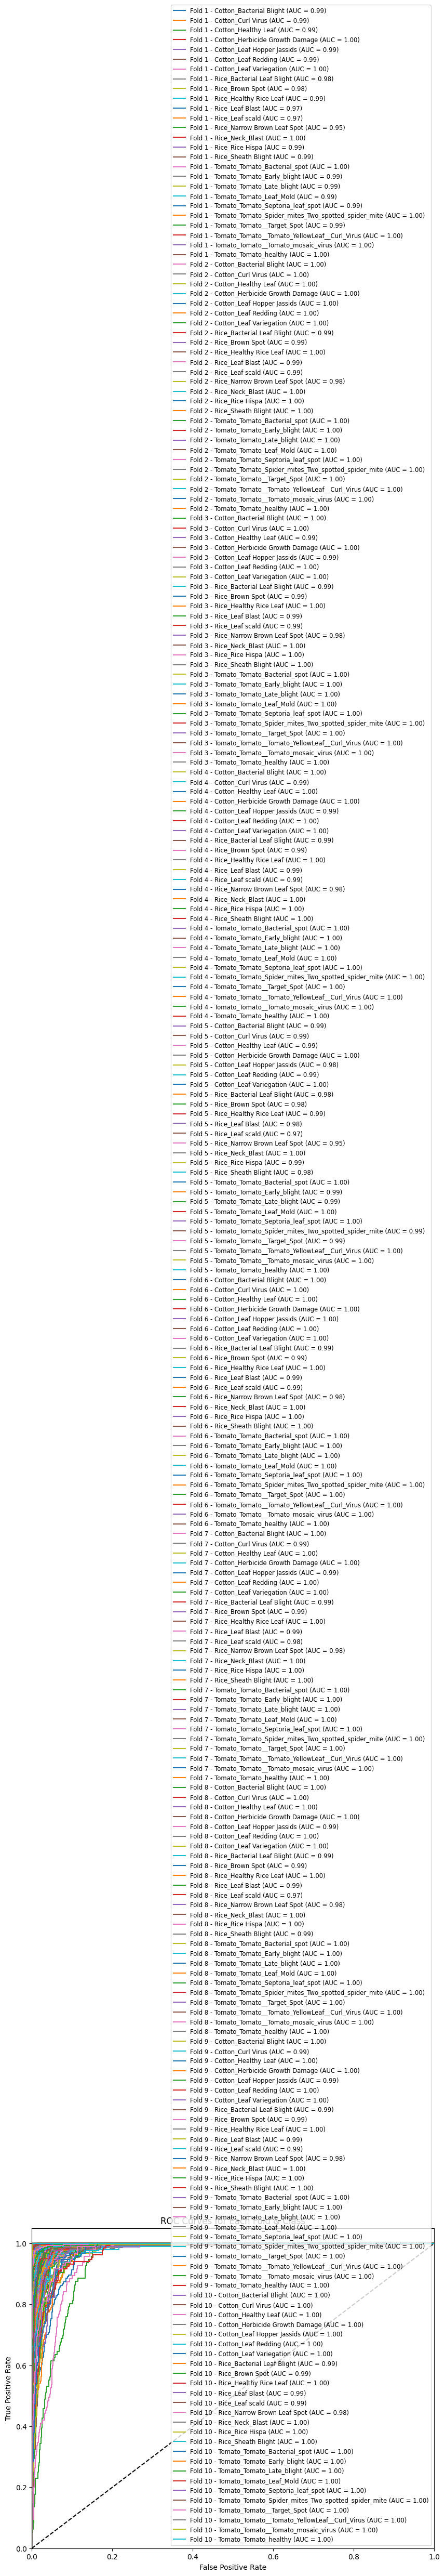

In [6]:
# -------------------
# Plot ROC curves for all folds
# -------------------
plt.figure(figsize=(10, 8))
for fold, cls, fpr, tpr, roc_auc in roc_data:
    plt.plot(fpr, tpr, label=f'Fold {fold} - {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold & Class')
plt.legend(loc='lower right', fontsize='small')
plt.show()